In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
if  not 'juxtorpus' in os.listdir():
    os.chdir('../../')
assert 'juxtorpus' in os.listdir(), f"Working directory should be at juxtorpus. But at {os.getcwd()}"
f"Working directory: {os.getcwd()}"

In [3]:
# imports
import pandas as pd
from juxtorpus.corpus.app import App
from juxtorpus.corpus.topic_model import LDA
from juxtorpus.viz.corpus import timeline, timelines, wordcloud
from juxtorpus.viz.item_timeline import ItemTimeline
from juxtorpus.matchers import is_hashtag

In [4]:
# this must be set after all the imports - third party libs can override this
import warnings
warnings.filterwarnings('ignore')

# Digital Humanities Day Demo

Juxtorpus: 2 parts - Jux and Corpus which is a play on words for juxtapose and corpus. It is mostly an exploratory tool so it's sort of up to the users as to how they want to use it.

This demo is just a preview on this tool so we won't go into any technical implementation details, I'll just try to showcase some of the key features and we'd appreciate some feedback at the end of the session.

For this demo, we have sampled a set of tweets but the tool is designed to be general purpose so you can use it with news articles, papers or any sorts of text data.

We will split the demo into 2 short sessions, about 15minutes each. The first session is focused on building what we call a 'Corpus' and what we can do with it. The next session is on Jux itself.

# Session 1

# Building a Corpus

1. Building a corpus
2. Selecting the metadata and the appropriate data types. -> this will affect the slicer

In [5]:
corpora = App()

In [6]:
# NOTE: this will be deleted (just for testing)
from juxtorpus.corpus import CorpusBuilder
from juxtorpus.corpus.processors import process
import spacy
builder = CorpusBuilder('./notebooks/demos/Sample_Auspol_Tweets.csv')
builder.add_metas('created_at', 'datetime')
builder.add_metas('from_user_name', 'str')
builder.add_metas(['lang', 'location', 'tweet_type'], 'category')
builder.add_metas('retweet_count')
builder.set_text_column('text')
corpora['auspol'] = process(builder.build(), nlp=spacy.blank('en'), source='tweets')

In [7]:
corpora.corpus_builder()

In [8]:
# This cell will be deleted.
# NOTE: little delay in SpacyCorpus hack when building corpus (logger info have been taken off.)
type(corpora['auspol']) # just to show its a SpacyCorpus (hack)

juxtorpus.corpus.corpus.SpacyCorpus

In [9]:
corpora.corpus_registry()   # parent is later explained in the next section

GridBox(children=(VBox(children=(HBox(children=(Label(value='Corpus ID', layout=Layout(display='flex', justify…

In [10]:
corpus = corpora['auspol']
corpus.summary()

Corpus Type                                                      SpacyCorpus
Number of Documents                                                    50000
Number of Total Words                                                 744733
Size of Vocabulary                                                     27425
mean Words per Document                                                   14
min Words per Document                                                     0
max Words per Document                                                    59
metas                      location, lang, retweet_count, created_at, fro...
dtype: object

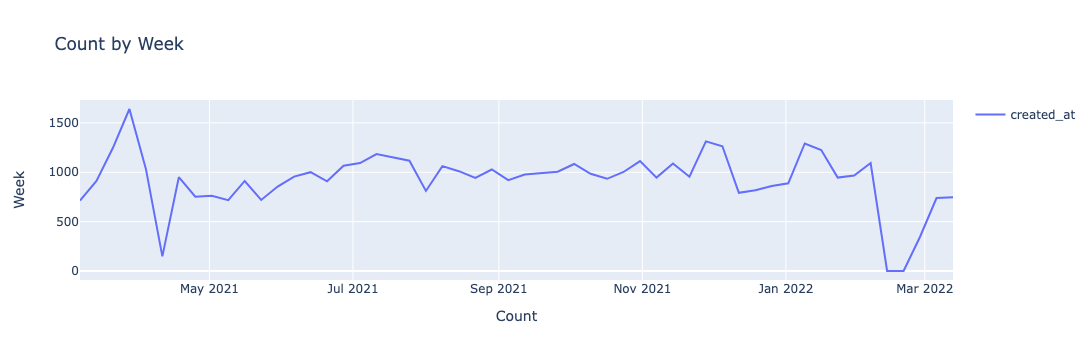

In [11]:
FREQ = '1w'  # change to 1m
META_ID = 'created_at'
# timeline(corpus, META_ID, freq=FREQ)
corpus.viz.timeline(META_ID, freq=FREQ)

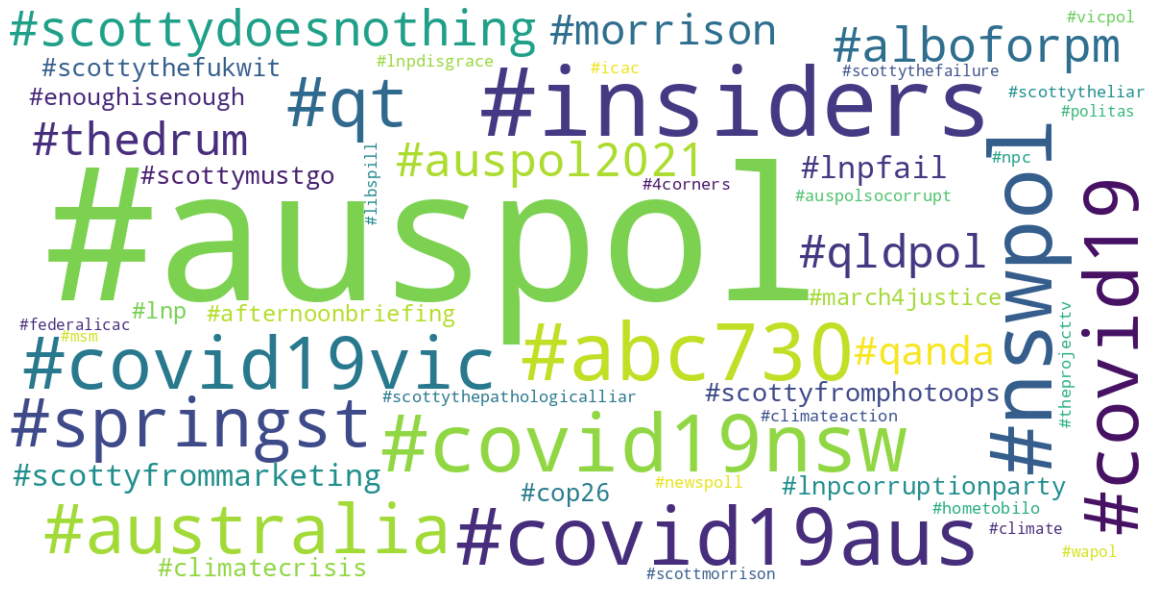

In [12]:
MAX_WORDS = 50   # change to 100
TYPE = 'hashtag'   # change to hashtag, mention
# wordcloud(corpus, max_words=MAX_WORDS, word_type=TYPE)
corpus.viz.wordcloud(max_words=MAX_WORDS, word_type=TYPE)

In [13]:
# item timeline

META_ID = 'created_at'
FREQ = '1w'

# user defined function in creating a custom dtm (document-term-matrix)
matcher = is_hashtag(corpus.nlp.vocab)
def extract_hashtags(doc): return [doc[s:e].text.lower() for _, s, e in matcher(doc)]
dtm = corpus.create_custom_dtm(extract_hashtags)

item_timeline = ItemTimeline.from_corpus(corpus, META_ID, FREQ, custom_dtm=True)
item_timeline.render()

FigureWidget({
    'data': [{'marker': {'color': 'rgba(60,134,0,1.0)'},
              'mode': 'lines+markers+t…

# Slicing a Corpus

In [14]:
# NOTE: This will be deleted
auspol = corpora['auspol']
corpora['jan'] = auspol.slicer.filter_by_datetime('created_at', start='01 Jan 2022', end='30 Jan 2022')
corpora['jun'] = auspol.slicer.filter_by_datetime('created_at', start='01 Jun 2021', end='30 Jun 2021')
corpora

len(corpora['jan']), len(corpora['jun'])

(4498, 4174)

In [15]:
# corpora['jan'].dtm

In [16]:
# NOTE: Slicing here (notice I have combined the registry and slicer when using corpus_slicer)
# show size preview, and adding multiple operations
corpora.corpus_slicer()

# lang = en -> english only
# see corpus size
# created_at = jan (01/01/2022 - 30/) -> datetime slicing
# multiple slicing operations
# slice

# created_at = jun -> add non overlapping datetime -> show corpus size
# lang + jun
# slice


# select 'jun'
# tweet_type = original
# retweet_number = min 5 -> jun


In [17]:
# NOTE: this will be deleted
corpora['jun-orig-rt5+'] = corpora['jun'].slicer.filter_by_item('tweet_type', 'Original').slicer.filter_by_range('retweet_count', min_=5)

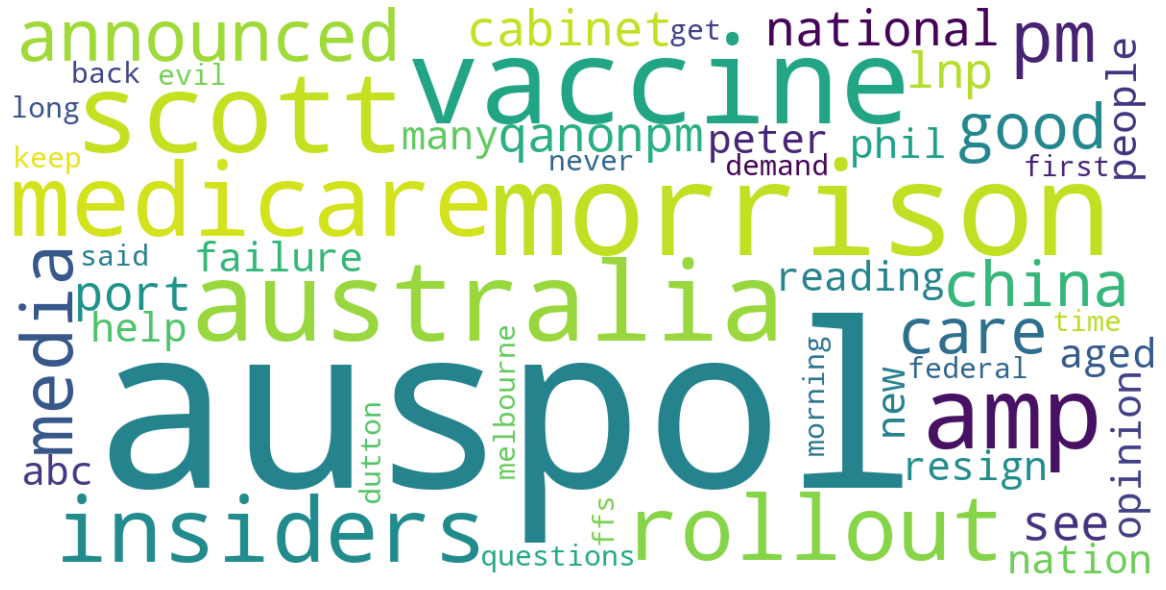

In [18]:
MAX_WORDS = 50
corpora['jun-orig-rt5+'].viz.wordcloud(max_words=MAX_WORDS)

In [19]:
NUM_TOPICS = 10
lda = LDA(corpora['auspol'], num_topics=NUM_TOPICS).build('tf')
lda.add_results_to_corpus()
# lda.widget()

In [20]:
corpora.corpus_slicer()

In [21]:
# NOTE: this will be deleted

corpora['TM2'] = corpora['auspol'].slicer.filter_by_range('#lda_topic_2', min_=0.5)
corpora['TM8'] = corpora['auspol'].slicer.filter_by_range('#lda_topic_8', min_=0.5)

In [23]:
META_ID = 'created_at'
FREQ = '1w'
timelines(corpora, ['TM2', 'TM8'], META_ID, FREQ)